# Face Generation

In this project, you'll define and train a DCGAN on a dataset of faces. Your goal is to get a generator network to generate *new* images of faces that look as realistic as possible!

The project will be broken down into a series of tasks from **loading in data to defining and training adversarial networks**. At the end of the notebook, you'll be able to visualize the results of your trained Generator to see how it performs; your generated samples should look like fairly realistic faces with small amounts of noise.

### Get the Data

You'll be using the [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) to train your adversarial networks.

This dataset is more complex than the number datasets (like MNIST or SVHN) you've been working with, and so, you should prepare to define deeper networks and train them for a longer time to get good results. It is suggested that you utilize a GPU for training.

### Pre-processed Data

Since the project's main focus is on building the GANs, we've done *some* of the pre-processing for you. Each of the CelebA images has been cropped to remove parts of the image that don't include a face, then resized down to 64x64x3 NumPy images. Some sample data is show below.

<img src='assets/processed_face_data.png' width=60% />

> If you are working locally, you can download this data [by clicking here](https://s3.amazonaws.com/video.udacity-data.com/topher/2018/November/5be7eb6f_processed-celeba-small/processed-celeba-small.zip)

This is a zip file that you'll need to extract in the home directory of this notebook for further loading and processing. After extracting the data, you should be left with a directory of data `processed_celeba_small/`

In [ ]:
# can comment out after executing
# !unzip processed_celeba_small.zip

In [1]:
data_dir = 'processed_celeba_small/'
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import pickle as pkl
import matplotlib.pyplot as plt
import numpy as np
import problem_unittests as tests
#import helper

%matplotlib inline

## Visualize the CelebA Data

The [CelebA](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations. Since you're going to be generating faces, you won't need the annotations, you'll only need the images. Note that these are color images with [3 color channels (RGB)](https://en.wikipedia.org/wiki/Channel_(digital_image)#RGB_Images) each.

### Pre-process and Load the Data

Since the project's main focus is on building the GANs, we've done *some* of the pre-processing for you. Each of the CelebA images has been cropped to remove parts of the image that don't include a face, then resized down to 64x64x3 NumPy images. This *pre-processed* dataset is a smaller subset of the very large CelebA data.

> There are a few other steps that you'll need to **transform** this data and create a **DataLoader**.

#### Exercise: Complete the following `get_dataloader` function, such that it satisfies these requirements:

* Your images should be square, Tensor images of size `image_size x image_size` in the x and y dimension.
* Your function should return a DataLoader that shuffles and batches these Tensor images.

#### ImageFolder

To create a dataset given a directory of images, it's recommended that you use PyTorch's [ImageFolder](https://pytorch.org/docs/stable/torchvision/datasets.html#imagefolder) wrapper, with a root directory `processed_celeba_small/` and data transformation passed in.

In [2]:
# necessary imports
import torch
from torchvision import datasets
from torchvision import transforms

In [3]:
def get_dataloader(batch_size, image_size, data_dir='processed_celeba_small/'):
    """
    Batch the neural network data using DataLoader
    :param batch_size: The size of each batch; the number of images in a batch
    :param img_size: The square size of the image data (x, y)
    :param data_dir: Directory where image data is located
    :return: DataLoader with batched data
    """
    
    # TODO: Implement function and return a dataloader
    transform_data = transforms.Compose([
        transforms.Resize(image_size),
        transforms.ToTensor()])
    data = datasets.ImageFolder(data_dir, transform=transform_data)
    data_loader = torch.utils.data.DataLoader(data, batch_size=batch_size, shuffle=True)
    return data_loader


## Create a DataLoader

#### Exercise: Create a DataLoader `celeba_train_loader` with appropriate hyperparameters.

Call the above function and create a dataloader to view images. 
* You can decide on any reasonable `batch_size` parameter
* Your `image_size` **must be** `32`. Resizing the data to a smaller size will make for faster training, while still creating convincing images of faces!

In [4]:
# Define function hyperparameters
batch_size = 32
img_size = 32

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
# Call your function and get a dataloader
celeba_train_loader = get_dataloader(batch_size, img_size)


Next, you can view some images! You should seen square images of somewhat-centered faces.

Note: You'll need to convert the Tensor images into a NumPy type and transpose the dimensions to correctly display an image, suggested `imshow` code is below, but it may not be perfect.

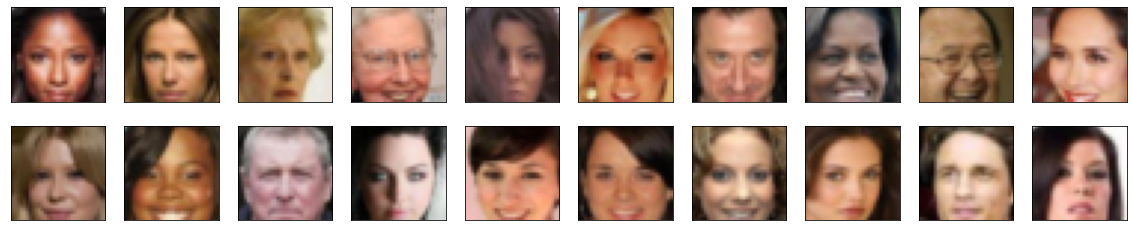

In [5]:
# helper display function
def imshow(img):
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
# obtain one batch of training images
dataiter = iter(celeba_train_loader)
images, _ = dataiter.next() # _ for no labels

# plot the images in the batch, along with the corresponding labels
fig = plt.figure(figsize=(20, 4))
plot_size=20
for idx in np.arange(plot_size):
    ax = fig.add_subplot(2, plot_size/2, idx+1, xticks=[], yticks=[])
    imshow(images[idx])

#### Exercise: Pre-process your image data and scale it to a pixel range of -1 to 1

You need to do a bit of pre-processing; you know that the output of a `tanh` activated generator will contain pixel values in a range from -1 to 1, and so, we need to rescale our training images to a range of -1 to 1. (Right now, they are in a range from 0-1.)

In [6]:
# TODO: Complete the scale function
def scale(x, feature_range=(-1, 1)):
    ''' Scale takes in an image x and returns that image, scaled
       with a feature_range of pixel values from -1 to 1. 
       This function assumes that the input x is already scaled from 0-1.'''
    # assume x is scaled to (0, 1)
    # scale to feature_range and return scaled x
    min_val, max_val = feature_range
    return (max_val - min_val) * x + min_val


In [7]:
"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
# check scaled range
# should be close to -1 to 1
img = images[0]
scaled_img = scale(img)

print('Min: ', scaled_img.min())
print('Max: ', scaled_img.max())

Min:  tensor(-0.9843)
Max:  tensor(0.9373)


---
# Define the Model

A GAN is comprised of two adversarial networks, a discriminator and a generator.

## Discriminator

Your first task will be to define the discriminator. This is a convolutional classifier like you've built before, only without any maxpooling layers. To deal with this complex data, it's suggested you use a deep network with **normalization**. You are also allowed to create any helper functions that may be useful.

#### Exercise: Complete the Discriminator class
* The inputs to the discriminator are 32x32x3 tensor images
* The output should be a single value that will indicate whether a given image is real or fake


In [8]:
import torch.nn as nn
import torch.nn.functional as F

In [9]:
def convolution(inputs, outputs, k_size=4, stride=2, padding=1, batch_norm=True):
    layers = []
    layers.append(
        nn.Conv2d(inputs, outputs, kernel_size=k_size, stride=stride, padding=padding, bias=False)
    )
    if batch_norm:
        layers.append(nn.BatchNorm2d(outputs))
    return nn.Sequential(*layers)

def convolution_transpose(inputs, outputs, k_size=4, stride=2, padding=1, batch_norm=True):
    layers = []
    layers.append(
        nn.ConvTranspose2d(inputs, outputs, kernel_size=k_size, stride=stride, padding=padding, bias=False)
    )
    if batch_norm:
        layers.append(nn.BatchNorm2d(outputs))
    return nn.Sequential(*layers)

In [10]:
class Discriminator(nn.Module):

    def __init__(self, conv_dim):
        """
        Initialize the Discriminator Module
        :param conv_dim: The depth of the first convolutional layer
        """
        super(Discriminator, self).__init__()

        # complete init function
        self.conv_dim = conv_dim
        # 3 RGB inputs, first layer
        # 3 x 32 x 32
        self.conv1 = convolution(3, conv_dim, batch_norm=False)
        # 16
        self.conv2 = convolution(conv_dim, conv_dim*2)
        # 8
        self.conv3 = convolution(conv_dim*2, conv_dim*4)
        # 4
        self.fc = nn.Linear(conv_dim*64, 1)

    def forward(self, x):
        """
        Forward propagation of the neural network
        :param x: The input to the neural network     
        :return: Discriminator logits; the output of the neural network
        """
        # define feedforward behavior
        c1_out = F.leaky_relu(self.conv1(x), 0.2)
        c2_out = F.leaky_relu(self.conv2(c1_out), 0.2)
        c3_out = F.leaky_relu(self.conv3(c2_out), 0.2)
        c_out = c3_out.view(-1, self.conv_dim*4*4*4)
        x = self.fc(c_out)
        return x


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(Discriminator)

Tests Passed


## Generator

The generator should upsample an input and generate a *new* image of the same size as our training data `32x32x3`. This should be mostly transpose convolutional layers with normalization applied to the outputs.

#### Exercise: Complete the Generator class
* The inputs to the generator are vectors of some length `z_size`
* The output should be a image of shape `32x32x3`

In [11]:
class Generator(nn.Module):
    
    def __init__(self, z_size, conv_dim):
        """
        Initialize the Generator Module
        :param z_size: The length of the input latent vector, z
        :param conv_dim: The depth of the inputs to the *last* transpose convolutional layer
        """
        super(Generator, self).__init__()

        # complete init function
        self.z_size = z_size
        self.conv_dim = conv_dim
        self.fc = nn.Linear(z_size, self.conv_dim*4*4*4)
        self.conv2d_trans1 = convolution_transpose(self.conv_dim*4, self.conv_dim*2)
        self.conv2d_trans2 = convolution_transpose(self.conv_dim*2, self.conv_dim)
        # 3 RGB output
        self.conv2d_trans3 = convolution_transpose(self.conv_dim, 3, batch_norm=False)
        

    def forward(self, x):
        """
        Forward propagation of the neural network
        :param x: The input to the neural network     
        :return: A 32x32x3 Tensor image as output
        """
        # define feedforward behavior
        fc_out = self.fc(x)
        # reshape
        fc_out = fc_out.view(-1, self.conv_dim *4, 4, 4)
        
        out_conv_trans1 = F.relu(self.conv2d_trans1(fc_out))
        out_conv_trans2 = F.relu(self.conv2d_trans2(out_conv_trans1))
        out_conv_trans3 = self.conv2d_trans3(out_conv_trans2)
        x = torch.tanh(out_conv_trans3)
        return x

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(Generator)

Tests Passed


## Initialize the weights of your networks

To help your models converge, you should initialize the weights of the convolutional and linear layers in your model. From reading the [original DCGAN paper](https://arxiv.org/pdf/1511.06434.pdf), they say:
> All weights were initialized from a zero-centered Normal distribution with standard deviation 0.02.

So, your next task will be to define a weight initialization function that does just this!

You can refer back to the lesson on weight initialization or even consult existing model code, such as that from [the `networks.py` file in CycleGAN Github repository](https://github.com/junyanz/pytorch-CycleGAN-and-pix2pix/blob/master/models/networks.py) to help you complete this function.

#### Exercise: Complete the weight initialization function

* This should initialize only **convolutional** and **linear** layers
* Initialize the weights to a normal distribution, centered around 0, with a standard deviation of 0.02.
* The bias terms, if they exist, may be left alone or set to 0.

In [12]:
def weights_init_normal(m):
    """
    Applies initial weights to certain layers in a model .
    The weights are taken from a normal distribution 
    with mean = 0, std dev = 0.02.
    :param m: A module or layer in a network    
    """
    # classname will be something like:
    # `Conv`, `BatchNorm2d`, `Linear`, etc.
    classname = m.__class__.__name__
    
    # TODO: Apply initial weights to convolutional and linear layers
    if 'Conv' in classname or 'Linear' in classname:
        torch.nn.init.normal_(m.weight.data, 0, 0.02)
    

## Build complete network

Define your models' hyperparameters and instantiate the discriminator and generator from the classes defined above. Make sure you've passed in the correct input arguments.

#### Exercise: Define model hyperparameters

In [13]:
"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
def build_network(d_conv_dim, g_conv_dim, z_size):
    # define discriminator and generator
    D = Discriminator(d_conv_dim)
    G = Generator(z_size=z_size, conv_dim=g_conv_dim)

    # initialize model weights
    D.apply(weights_init_normal)
    G.apply(weights_init_normal)

    print(D)
    print()
    print(G)
    
    return D, G


In [14]:
# Define model hyperparams
d_conv_dim = 32
g_conv_dim = 32
z_size = 512

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
D, G = build_network(d_conv_dim, g_conv_dim, z_size)

Discriminator(
  (conv1): Sequential(
    (0): Conv2d(3, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  )
  (conv2): Sequential(
    (0): Conv2d(32, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv3): Sequential(
    (0): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (fc): Linear(in_features=2048, out_features=1, bias=True)
)

Generator(
  (fc): Linear(in_features=512, out_features=2048, bias=True)
  (conv2d_trans1): Sequential(
    (0): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv2d_trans2): Sequential(
    (0): ConvTranspose2d(64, 32, kernel_size=(4, 4), stride=(2, 2), padding=

### Training on GPU

Check if you can train on GPU. Here, we'll set this as a boolean variable `train_on_gpu`. Later, you'll be responsible for making sure that 
>* Models,
* Model inputs, and
* Loss function arguments

Are moved to GPU, where appropriate.

In [15]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import torch

# Check for a GPU
train_on_gpu = torch.cuda.is_available()
if not train_on_gpu:
    print('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Training on GPU!')

Training on GPU!


---
## Discriminator and Generator Losses

Now we need to calculate the losses for both types of adversarial networks.

### Discriminator Losses

> * For the discriminator, the total loss is the sum of the losses for real and fake images, `d_loss = d_real_loss + d_fake_loss`. 
* Remember that we want the discriminator to output 1 for real images and 0 for fake images, so we need to set up the losses to reflect that.


### Generator Loss

The generator loss will look similar only with flipped labels. The generator's goal is to get the discriminator to *think* its generated images are *real*.

#### Exercise: Complete real and fake loss functions

**You may choose to use either cross entropy or a least squares error loss to complete the following `real_loss` and `fake_loss` functions.**

In [16]:
def real_loss(D_out):
    '''Calculates how close discriminator outputs are to being real.
       param, D_out: discriminator logits
       return: real loss'''
    batch_size = D_out.size(0)
    #1s
    labels = torch.ones(batch_size)
    if train_on_gpu:
        labels = labels.cuda()
    criterion =nn.BCEWithLogitsLoss()
    loss = criterion(D_out.squeeze(), labels)
    return loss

def fake_loss(D_out):
    '''Calculates how close discriminator outputs are to being fake.
       param, D_out: discriminator logits
       return: fake loss'''
    batch_size = D_out.size(0)
    #0s
    labels = torch.zeros(batch_size)
    if train_on_gpu:
        labels = labels.cuda()
    criterion =nn.BCEWithLogitsLoss()
    loss = criterion(D_out.squeeze(), labels)
    return loss

## Optimizers

#### Exercise: Define optimizers for your Discriminator (D) and Generator (G)

Define optimizers for your models with appropriate hyperparameters.

In [17]:
import torch.optim as optim

learning_rate = 0.0002
b1 = 0.5
b2 = 0.999
# Create optimizers for the discriminator D and generator G
d_optimizer = optim.Adam(D.parameters(), learning_rate, [b1, b2])
g_optimizer = optim.Adam(G.parameters(), learning_rate, [b1, b2])

---
## Training

Training will involve alternating between training the discriminator and the generator. You'll use your functions `real_loss` and `fake_loss` to help you calculate the discriminator losses.

* You should train the discriminator by alternating on real and fake images
* Then the generator, which tries to trick the discriminator and should have an opposing loss function


#### Saving Samples

You've been given some code to print out some loss statistics and save some generated "fake" samples.

#### Exercise: Complete the training function

Keep in mind that, if you've moved your models to GPU, you'll also have to move any model inputs to GPU.

In [18]:
def train(D, G, n_epochs, print_every=50):
    '''Trains adversarial networks for some number of epochs
       param, D: the discriminator network
       param, G: the generator network
       param, n_epochs: number of epochs to train for
       param, print_every: when to print and record the models' losses
       return: D and G losses'''
    
    # move models to GPU
    if train_on_gpu:
        D.cuda()
        G.cuda()

    # keep track of loss and generated, "fake" samples
    samples = []
    losses = []

    # Get some fixed data for sampling. These are images that are held
    # constant throughout training, and allow us to inspect the model's performance
    sample_size=16
    fixed_z = np.random.uniform(-1, 1, size=(sample_size, z_size))
    fixed_z = torch.from_numpy(fixed_z).float()
    # move z to GPU if available
    if train_on_gpu:
        fixed_z = fixed_z.cuda()

    # epoch training loop
    for epoch in range(n_epochs):

        # batch training loop
        for batch_i, (real_images, _) in enumerate(celeba_train_loader):

            batch_size = real_images.size(0)
            real_images = scale(real_images)

            # ===============================================
            #         YOUR CODE HERE: TRAIN THE NETWORKS
            # ===============================================
            
            # 1. Train the discriminator on real and fake images
            d_optimizer.zero_grad()
            if train_on_gpu:
                real_images = real_images.cuda()
            # take real images, run them through discriminator
            D_real_logits = D(real_images)
            # get loss from discriminator based on real loss
            d_real_loss = real_loss(D_real_logits)
            
            # train discriminator with fake images
            z = np.random.uniform(-1, 1, size=(batch_size, z_size))
            z = torch.from_numpy(z).float()
            # move to gpu
            if train_on_gpu:
                z = z.cuda()
            # get fake images from generator
            fake_images = G(z)
            # compute loss of discriminator with fake images
            D_fake_logits = D(fake_images)
            d_fake_loss = fake_loss(D_fake_logits)
            
            d_loss = d_real_loss + d_fake_loss
            d_loss.backward()
            d_optimizer.step()

            # 2. Train the generator with an adversarial loss
            g_optimizer.zero_grad()
            # generate latent variable to get fake images
            z = np.random.uniform(-1, 1, size=(batch_size, z_size))
            z = torch.from_numpy(z).float()
            # move to gpu
            if train_on_gpu:
                z = z.cuda()
            # get fake images
            fake_images = G(z)
            # compute fake_logits from updated discriminator
            D_fake_logits = D(fake_images)
            # compute real_loss from fake_logits
            g_loss = real_loss(D_fake_logits)
            # backprop
            g_loss.backward()
            # update weights
            g_optimizer.step()
            # ===============================================
            #              END OF YOUR CODE
            # ===============================================

            # Print some loss stats
            if batch_i % print_every == 0:
                # append discriminator loss and generator loss
                losses.append((d_loss.item(), g_loss.item()))
                # print discriminator and generator loss
                print('Epoch [{:5d}/{:5d}] | d_loss: {:6.4f} | g_loss: {:6.4f}'.format(
                        epoch+1, n_epochs, d_loss.item(), g_loss.item()))


        ## AFTER EACH EPOCH##    
        # this code assumes your generator is named G, feel free to change the name
        # generate and save sample, fake images
        G.eval() # for generating samples
        samples_z = G(fixed_z)
        samples.append(samples_z)
        G.train() # back to training mode

    # Save training generator samples
    with open('train_samples.pkl', 'wb') as f:
        pkl.dump(samples, f)
    
    # finally return losses
    return losses

Set your number of training epochs and train your GAN!

In [28]:
# set number of epochs 
n_epochs = 30


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
# call training function
losses = train(D, G, n_epochs=n_epochs)

Epoch [    1/   30] | d_loss: 0.2978 | g_loss: 2.7857
Epoch [    1/   30] | d_loss: 0.4608 | g_loss: 2.4949
Epoch [    1/   30] | d_loss: 0.2595 | g_loss: 2.9644
Epoch [    1/   30] | d_loss: 0.4469 | g_loss: 3.0971
Epoch [    1/   30] | d_loss: 0.1389 | g_loss: 2.6158
Epoch [    1/   30] | d_loss: 0.4310 | g_loss: 3.3882
Epoch [    1/   30] | d_loss: 0.9298 | g_loss: 2.3962
Epoch [    1/   30] | d_loss: 0.1550 | g_loss: 2.9391
Epoch [    1/   30] | d_loss: 0.5881 | g_loss: 2.6839
Epoch [    1/   30] | d_loss: 0.1660 | g_loss: 3.1669
Epoch [    1/   30] | d_loss: 0.2416 | g_loss: 3.6607
Epoch [    1/   30] | d_loss: 0.3832 | g_loss: 2.3983
Epoch [    1/   30] | d_loss: 0.5496 | g_loss: 2.7001
Epoch [    1/   30] | d_loss: 0.2536 | g_loss: 2.5388
Epoch [    1/   30] | d_loss: 0.1950 | g_loss: 4.0191
Epoch [    1/   30] | d_loss: 0.1361 | g_loss: 3.6194
Epoch [    1/   30] | d_loss: 0.5558 | g_loss: 3.1674
Epoch [    1/   30] | d_loss: 0.5580 | g_loss: 3.3974
Epoch [    1/   30] | d_loss

Epoch [    3/   30] | d_loss: 0.3994 | g_loss: 2.6532
Epoch [    3/   30] | d_loss: 0.4314 | g_loss: 4.4894
Epoch [    3/   30] | d_loss: 0.3299 | g_loss: 2.0885
Epoch [    3/   30] | d_loss: 0.0865 | g_loss: 3.7674
Epoch [    3/   30] | d_loss: 0.3640 | g_loss: 2.4063
Epoch [    3/   30] | d_loss: 0.2785 | g_loss: 2.2146
Epoch [    3/   30] | d_loss: 0.3083 | g_loss: 2.6671
Epoch [    3/   30] | d_loss: 0.2030 | g_loss: 3.0125
Epoch [    3/   30] | d_loss: 0.2757 | g_loss: 2.8763
Epoch [    3/   30] | d_loss: 0.2119 | g_loss: 2.6034
Epoch [    3/   30] | d_loss: 0.3068 | g_loss: 1.4186
Epoch [    3/   30] | d_loss: 0.4695 | g_loss: 4.1015
Epoch [    3/   30] | d_loss: 0.2215 | g_loss: 3.9752
Epoch [    3/   30] | d_loss: 0.2274 | g_loss: 3.1877
Epoch [    3/   30] | d_loss: 0.1423 | g_loss: 3.9608
Epoch [    3/   30] | d_loss: 0.3239 | g_loss: 2.1721
Epoch [    3/   30] | d_loss: 0.5386 | g_loss: 1.4399
Epoch [    3/   30] | d_loss: 0.2184 | g_loss: 6.5114
Epoch [    3/   30] | d_loss

Epoch [    6/   30] | d_loss: 0.0943 | g_loss: 3.4203
Epoch [    6/   30] | d_loss: 0.1589 | g_loss: 4.2347
Epoch [    6/   30] | d_loss: 0.3168 | g_loss: 3.7717
Epoch [    6/   30] | d_loss: 0.2407 | g_loss: 5.1123
Epoch [    6/   30] | d_loss: 0.2225 | g_loss: 3.0464
Epoch [    6/   30] | d_loss: 0.2040 | g_loss: 3.9523
Epoch [    6/   30] | d_loss: 0.1909 | g_loss: 5.0381
Epoch [    6/   30] | d_loss: 0.2329 | g_loss: 4.6352
Epoch [    6/   30] | d_loss: 0.4090 | g_loss: 2.8577
Epoch [    6/   30] | d_loss: 0.3393 | g_loss: 3.2467
Epoch [    6/   30] | d_loss: 0.1052 | g_loss: 2.9830
Epoch [    6/   30] | d_loss: 0.0936 | g_loss: 5.0908
Epoch [    6/   30] | d_loss: 0.2130 | g_loss: 3.3423
Epoch [    6/   30] | d_loss: 0.3045 | g_loss: 3.3206
Epoch [    6/   30] | d_loss: 0.2048 | g_loss: 3.6378
Epoch [    6/   30] | d_loss: 0.1044 | g_loss: 3.8102
Epoch [    6/   30] | d_loss: 0.1783 | g_loss: 4.5865
Epoch [    6/   30] | d_loss: 0.1332 | g_loss: 3.7519
Epoch [    6/   30] | d_loss

Epoch [    9/   30] | d_loss: 0.2022 | g_loss: 4.8587
Epoch [    9/   30] | d_loss: 0.1522 | g_loss: 5.4762
Epoch [    9/   30] | d_loss: 0.8924 | g_loss: 1.0223
Epoch [    9/   30] | d_loss: 0.1962 | g_loss: 1.9858
Epoch [    9/   30] | d_loss: 0.1015 | g_loss: 4.3735
Epoch [    9/   30] | d_loss: 0.1021 | g_loss: 3.8181
Epoch [    9/   30] | d_loss: 0.1500 | g_loss: 1.9041
Epoch [    9/   30] | d_loss: 0.1413 | g_loss: 3.8365
Epoch [    9/   30] | d_loss: 0.0813 | g_loss: 4.7956
Epoch [    9/   30] | d_loss: 0.3043 | g_loss: 4.0421
Epoch [    9/   30] | d_loss: 0.1608 | g_loss: 3.8203
Epoch [    9/   30] | d_loss: 0.4534 | g_loss: 2.6860
Epoch [    9/   30] | d_loss: 0.2908 | g_loss: 2.4312
Epoch [    9/   30] | d_loss: 0.3529 | g_loss: 4.7117
Epoch [    9/   30] | d_loss: 0.2767 | g_loss: 4.1477
Epoch [    9/   30] | d_loss: 0.1181 | g_loss: 3.9848
Epoch [    9/   30] | d_loss: 0.0497 | g_loss: 3.6965
Epoch [    9/   30] | d_loss: 0.1146 | g_loss: 3.6825
Epoch [    9/   30] | d_loss

Epoch [   11/   30] | d_loss: 0.1571 | g_loss: 3.5648
Epoch [   11/   30] | d_loss: 0.3005 | g_loss: 4.3733
Epoch [   11/   30] | d_loss: 0.0809 | g_loss: 3.9393
Epoch [   11/   30] | d_loss: 0.0767 | g_loss: 3.1729
Epoch [   11/   30] | d_loss: 0.1235 | g_loss: 4.2181
Epoch [   11/   30] | d_loss: 0.1792 | g_loss: 3.1366
Epoch [   11/   30] | d_loss: 0.2852 | g_loss: 2.7651
Epoch [   11/   30] | d_loss: 0.4054 | g_loss: 3.9826
Epoch [   11/   30] | d_loss: 1.3067 | g_loss: 2.7454
Epoch [   11/   30] | d_loss: 0.2024 | g_loss: 2.7887
Epoch [   11/   30] | d_loss: 0.2434 | g_loss: 5.8383
Epoch [   11/   30] | d_loss: 0.3187 | g_loss: 3.3744
Epoch [   11/   30] | d_loss: 0.1106 | g_loss: 2.6942
Epoch [   11/   30] | d_loss: 0.0872 | g_loss: 5.0067
Epoch [   11/   30] | d_loss: 0.0742 | g_loss: 2.8650
Epoch [   11/   30] | d_loss: 0.0503 | g_loss: 4.1313
Epoch [   11/   30] | d_loss: 0.1354 | g_loss: 4.1704
Epoch [   11/   30] | d_loss: 0.1732 | g_loss: 4.2415
Epoch [   12/   30] | d_loss

Epoch [   14/   30] | d_loss: 0.0829 | g_loss: 4.3356
Epoch [   14/   30] | d_loss: 0.0687 | g_loss: 3.8826
Epoch [   14/   30] | d_loss: 0.0694 | g_loss: 5.2459
Epoch [   14/   30] | d_loss: 0.1834 | g_loss: 5.9384
Epoch [   14/   30] | d_loss: 0.0803 | g_loss: 5.0422
Epoch [   14/   30] | d_loss: 0.2269 | g_loss: 4.4111
Epoch [   14/   30] | d_loss: 0.0671 | g_loss: 5.5517
Epoch [   14/   30] | d_loss: 0.0965 | g_loss: 5.0419
Epoch [   14/   30] | d_loss: 0.1239 | g_loss: 1.8994
Epoch [   14/   30] | d_loss: 0.9017 | g_loss: 2.1730
Epoch [   14/   30] | d_loss: 0.4195 | g_loss: 5.1052
Epoch [   14/   30] | d_loss: 0.4024 | g_loss: 5.3085
Epoch [   14/   30] | d_loss: 0.6906 | g_loss: 1.7671
Epoch [   14/   30] | d_loss: 0.1363 | g_loss: 4.7500
Epoch [   14/   30] | d_loss: 0.2768 | g_loss: 2.5825
Epoch [   14/   30] | d_loss: 0.0577 | g_loss: 3.6677
Epoch [   14/   30] | d_loss: 0.2992 | g_loss: 3.7333
Epoch [   14/   30] | d_loss: 0.1022 | g_loss: 3.8117
Epoch [   14/   30] | d_loss

Epoch [   17/   30] | d_loss: 0.0919 | g_loss: 5.0835
Epoch [   17/   30] | d_loss: 0.1913 | g_loss: 3.6385
Epoch [   17/   30] | d_loss: 0.0951 | g_loss: 2.5775
Epoch [   17/   30] | d_loss: 0.1295 | g_loss: 4.1787
Epoch [   17/   30] | d_loss: 0.1942 | g_loss: 3.8603
Epoch [   17/   30] | d_loss: 0.2704 | g_loss: 3.9466
Epoch [   17/   30] | d_loss: 0.0805 | g_loss: 3.2562
Epoch [   17/   30] | d_loss: 0.2541 | g_loss: 4.3272
Epoch [   17/   30] | d_loss: 0.0317 | g_loss: 6.3288
Epoch [   17/   30] | d_loss: 0.2669 | g_loss: 3.6824
Epoch [   17/   30] | d_loss: 0.0959 | g_loss: 4.7310
Epoch [   17/   30] | d_loss: 0.1209 | g_loss: 4.5371
Epoch [   17/   30] | d_loss: 0.2728 | g_loss: 3.9673
Epoch [   17/   30] | d_loss: 0.1508 | g_loss: 4.0235
Epoch [   17/   30] | d_loss: 0.1077 | g_loss: 5.6240
Epoch [   17/   30] | d_loss: 0.0666 | g_loss: 5.0453
Epoch [   17/   30] | d_loss: 0.5739 | g_loss: 2.3557
Epoch [   17/   30] | d_loss: 0.1296 | g_loss: 4.3029
Epoch [   17/   30] | d_loss

Epoch [   19/   30] | d_loss: 0.0216 | g_loss: 3.7681
Epoch [   19/   30] | d_loss: 0.1033 | g_loss: 3.9219
Epoch [   19/   30] | d_loss: 0.1773 | g_loss: 5.3626
Epoch [   19/   30] | d_loss: 0.0610 | g_loss: 2.3045
Epoch [   19/   30] | d_loss: 0.4460 | g_loss: 3.7719
Epoch [   19/   30] | d_loss: 0.0563 | g_loss: 5.0344
Epoch [   19/   30] | d_loss: 0.2540 | g_loss: 3.7929
Epoch [   19/   30] | d_loss: 0.0368 | g_loss: 5.6735
Epoch [   19/   30] | d_loss: 0.1146 | g_loss: 4.4598
Epoch [   19/   30] | d_loss: 0.0986 | g_loss: 5.6763
Epoch [   19/   30] | d_loss: 0.0854 | g_loss: 3.5902
Epoch [   19/   30] | d_loss: 0.1769 | g_loss: 6.3141
Epoch [   19/   30] | d_loss: 0.2766 | g_loss: 5.5846
Epoch [   19/   30] | d_loss: 0.1154 | g_loss: 5.5464
Epoch [   19/   30] | d_loss: 0.3556 | g_loss: 5.2457
Epoch [   19/   30] | d_loss: 0.0419 | g_loss: 5.5230
Epoch [   19/   30] | d_loss: 0.0175 | g_loss: 5.7661
Epoch [   19/   30] | d_loss: 0.1503 | g_loss: 2.6632
Epoch [   20/   30] | d_loss

Epoch [   22/   30] | d_loss: 0.0562 | g_loss: 4.8293
Epoch [   22/   30] | d_loss: 0.1211 | g_loss: 4.0009
Epoch [   22/   30] | d_loss: 0.0392 | g_loss: 5.2805
Epoch [   22/   30] | d_loss: 0.0931 | g_loss: 5.2146
Epoch [   22/   30] | d_loss: 0.0894 | g_loss: 4.4639
Epoch [   22/   30] | d_loss: 1.2848 | g_loss: 0.3818
Epoch [   22/   30] | d_loss: 0.4513 | g_loss: 7.3642
Epoch [   22/   30] | d_loss: 0.7140 | g_loss: 5.3803
Epoch [   22/   30] | d_loss: 0.0583 | g_loss: 3.2366
Epoch [   22/   30] | d_loss: 0.1080 | g_loss: 4.4014
Epoch [   22/   30] | d_loss: 0.2125 | g_loss: 3.9191
Epoch [   22/   30] | d_loss: 0.0199 | g_loss: 6.1316
Epoch [   22/   30] | d_loss: 0.0458 | g_loss: 4.7868
Epoch [   22/   30] | d_loss: 0.0577 | g_loss: 6.1240
Epoch [   22/   30] | d_loss: 0.1440 | g_loss: 2.2597
Epoch [   22/   30] | d_loss: 0.0974 | g_loss: 4.6555
Epoch [   22/   30] | d_loss: 0.0519 | g_loss: 4.5657
Epoch [   22/   30] | d_loss: 0.0452 | g_loss: 4.3576
Epoch [   22/   30] | d_loss

Epoch [   25/   30] | d_loss: 0.0310 | g_loss: 4.3769
Epoch [   25/   30] | d_loss: 0.4022 | g_loss: 6.0056
Epoch [   25/   30] | d_loss: 0.1352 | g_loss: 4.1753
Epoch [   25/   30] | d_loss: 0.1056 | g_loss: 5.2495
Epoch [   25/   30] | d_loss: 0.0947 | g_loss: 6.0626
Epoch [   25/   30] | d_loss: 0.1189 | g_loss: 4.9582
Epoch [   25/   30] | d_loss: 0.0783 | g_loss: 5.4618
Epoch [   25/   30] | d_loss: 0.1337 | g_loss: 5.2169
Epoch [   25/   30] | d_loss: 0.0322 | g_loss: 3.9700
Epoch [   25/   30] | d_loss: 0.6005 | g_loss: 3.5179
Epoch [   25/   30] | d_loss: 0.1593 | g_loss: 3.3817
Epoch [   25/   30] | d_loss: 0.0456 | g_loss: 5.7759
Epoch [   25/   30] | d_loss: 0.1761 | g_loss: 3.7509
Epoch [   25/   30] | d_loss: 0.2534 | g_loss: 5.5411
Epoch [   25/   30] | d_loss: 0.2091 | g_loss: 5.0745
Epoch [   25/   30] | d_loss: 0.0668 | g_loss: 5.0769
Epoch [   25/   30] | d_loss: 0.4095 | g_loss: 6.1255
Epoch [   25/   30] | d_loss: 0.0779 | g_loss: 5.8996
Epoch [   25/   30] | d_loss

Epoch [   27/   30] | d_loss: 0.0329 | g_loss: 5.5453
Epoch [   27/   30] | d_loss: 0.3368 | g_loss: 4.8950
Epoch [   27/   30] | d_loss: 0.0248 | g_loss: 6.8578
Epoch [   27/   30] | d_loss: 0.0383 | g_loss: 4.2227
Epoch [   27/   30] | d_loss: 0.0548 | g_loss: 4.8681
Epoch [   27/   30] | d_loss: 0.1706 | g_loss: 5.3609
Epoch [   27/   30] | d_loss: 0.0539 | g_loss: 4.0465
Epoch [   27/   30] | d_loss: 0.1167 | g_loss: 5.8361
Epoch [   27/   30] | d_loss: 0.1093 | g_loss: 5.3564
Epoch [   27/   30] | d_loss: 0.0642 | g_loss: 3.4979
Epoch [   27/   30] | d_loss: 0.0689 | g_loss: 5.7359
Epoch [   27/   30] | d_loss: 0.4710 | g_loss: 3.2120
Epoch [   27/   30] | d_loss: 0.0505 | g_loss: 4.6978
Epoch [   27/   30] | d_loss: 0.0434 | g_loss: 5.0267
Epoch [   27/   30] | d_loss: 0.0564 | g_loss: 7.5902
Epoch [   27/   30] | d_loss: 0.2165 | g_loss: 4.3802
Epoch [   27/   30] | d_loss: 0.0308 | g_loss: 8.4649
Epoch [   27/   30] | d_loss: 0.2918 | g_loss: 3.5627
Epoch [   28/   30] | d_loss

Epoch [   30/   30] | d_loss: 0.0464 | g_loss: 5.9670
Epoch [   30/   30] | d_loss: 0.0201 | g_loss: 6.4642
Epoch [   30/   30] | d_loss: 0.0295 | g_loss: 4.8397
Epoch [   30/   30] | d_loss: 0.0345 | g_loss: 4.9743
Epoch [   30/   30] | d_loss: 0.0526 | g_loss: 4.6561
Epoch [   30/   30] | d_loss: 0.1027 | g_loss: 7.8863
Epoch [   30/   30] | d_loss: 1.4979 | g_loss: 1.2616
Epoch [   30/   30] | d_loss: 0.0889 | g_loss: 3.6005
Epoch [   30/   30] | d_loss: 0.1404 | g_loss: 4.1539
Epoch [   30/   30] | d_loss: 0.2059 | g_loss: 2.9385
Epoch [   30/   30] | d_loss: 0.0727 | g_loss: 5.6426
Epoch [   30/   30] | d_loss: 0.1099 | g_loss: 6.4805
Epoch [   30/   30] | d_loss: 0.1392 | g_loss: 5.5411
Epoch [   30/   30] | d_loss: 0.0545 | g_loss: 6.0750
Epoch [   30/   30] | d_loss: 0.0348 | g_loss: 5.6006
Epoch [   30/   30] | d_loss: 0.3089 | g_loss: 6.8769
Epoch [   30/   30] | d_loss: 0.2472 | g_loss: 4.7726
Epoch [   30/   30] | d_loss: 0.2701 | g_loss: 3.5716
Epoch [   30/   30] | d_loss

## Training loss

Plot the training losses for the generator and discriminator, recorded after each epoch.

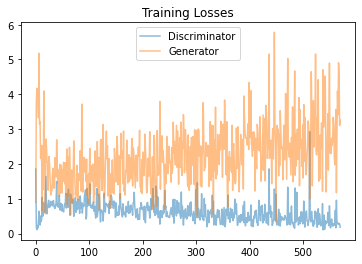

In [24]:
# following was trained with 10 epochs
fig, ax = plt.subplots()
losses = np.array(losses)
plt.plot(losses.T[0], label='Discriminator', alpha=0.5)
plt.plot(losses.T[1], label='Generator', alpha=0.5)
plt.title("Training Losses")
plt.legend()

## Generator samples from training

View samples of images from the generator, and answer a question about the strengths and weaknesses of your trained models.

In [25]:
# helper function for viewing a list of passed in sample images
def view_samples(epoch, samples):
    fig, axes = plt.subplots(figsize=(16,4), nrows=2, ncols=8, sharey=True, sharex=True)
    for ax, img in zip(axes.flatten(), samples[epoch]):
        img = img.detach().cpu().numpy()
        img = np.transpose(img, (1, 2, 0))
        img = ((img + 1)*255 / (2)).astype(np.uint8)
        ax.xaxis.set_visible(False)
        ax.yaxis.set_visible(False)
        im = ax.imshow(img.reshape((32,32,3)))

In [26]:
# Load samples from generator, taken while training
with open('train_samples.pkl', 'rb') as f:
    samples = pkl.load(f)

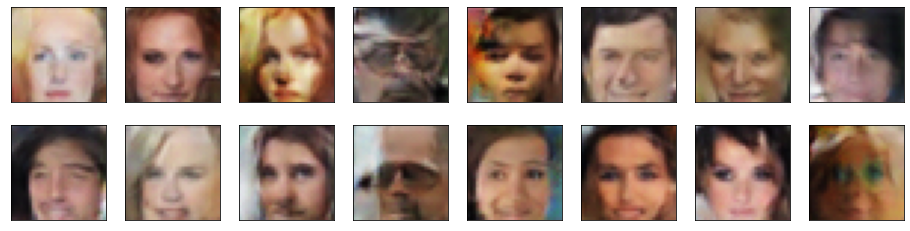

In [27]:
# the following network was trained with 10 epochs
_ = view_samples(-1, samples)

### Question: What do you notice about your generated samples and how might you improve this model?
When you answer this question, consider the following factors:
* The dataset is biased; it is made of "celebrity" faces that are mostly white
* Model size; larger models have the opportunity to learn more features in a data feature space
* Optimization strategy; optimizers and number of epochs affect your final result


**Answer:** (Write your answer in this cell)
Most of these faces are white. The dataset is biased, the results are biased as well. I believe the more diverse the dataset, we may get diverse results (generated faces). 

I tried training the network for 10 epochs, 30 epochs. I stuck to the adam optimizer (since it is fairly popular for computer vision/image processing tasks). I tried varying the size of `z` (tried 256, 512). Results with `z = 512` was better. However, they weren't drastically different. Both of them didn't seem to help with diverging of generator loss.

***Results for 10 epochs***:
Some of the faces generated seem real, rest are not very convincing (see image above). We can generate more real faces with more complex models. I tried playing around with batch size, the size of `z`. However, the results didn't seem very different. Within a few epochs, the discriminator loss is fairly low. The generator loss seems to be increasing a slowly. The losses are diverging. 

***Results for 30 epochs***:
I tried training it longer (see image below) for 30 epochs. Some of the generated images are better. However, they are not drastically different. The discriminator loss is fairly flat. However, the generator loss diverged further if I trained it longer. So, epochs may not be the hyper-parameter to tweak.

Complex network (with more layers) may be the right way to go about solving this problem. I need to spend a lot more time on tweaking network architecture (adding more layers), tweaking learning rates to get better results.

Other complex techniques (to get better results) can involve different learning rates for discriminator and generator.


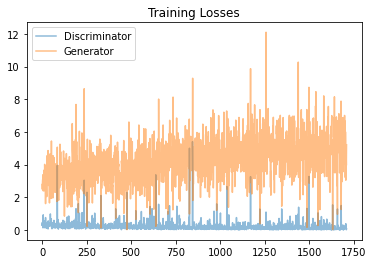

In [31]:
# following was trained with 30 epochs
# Load samples from generator, taken while training
with open('train_samples.pkl', 'rb') as f:
    samples = pkl.load(f)
# plot losses again
fig, ax = plt.subplots()
losses = np.array(losses)
plt.plot(losses.T[0], label='Discriminator', alpha=0.5)
plt.plot(losses.T[1], label='Generator', alpha=0.5)
plt.title("Training Losses")
plt.legend()



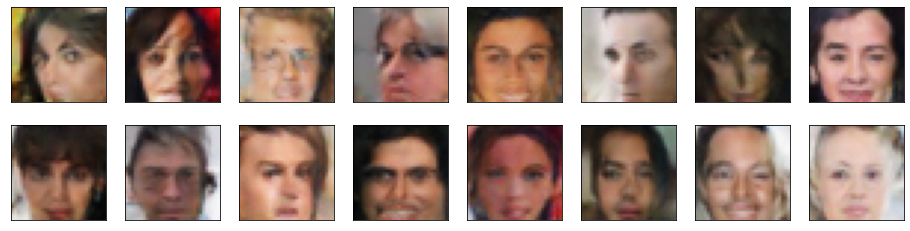

In [32]:
# the following network was trained with 30 epochs
_ = view_samples(-1, samples)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "problem_unittests.py" files in your submission.